# Plot gauge levels for the River Exe at Exe Bridges

Access the data using the `intake` cataloge and read the gauge data into a "lazy" (dask) data frame.

In [1]:
import intake
gauge_archive = intake.cat.ea_realtime_flood_monitoring_archive.to_dask()

/opt/conda/lib/python3.6/site-packages/intake/source/discovery.py:39: UserWarning: Plugin name collision for "netcdf" from
    /opt/conda/lib/python3.6/site-packages/intake_iris/netcdf.py
and
    /opt/conda/lib/python3.6/site-packages/intake_xarray/netcdf.py
Keeping plugin from first location.
  % (plugin_name, orig_path, new_path))


Start up a compute cluster. This will allow us to paralise the computation.

In [2]:
from dask import delayed, bag as db
import pandas as pd
import distributed
from dask_kubernetes import KubeCluster
cluster = KubeCluster()
cluster.adapt(minimum=1, maximum=100)
client = distributed.Client(cluster)
cluster

Take a look at small amount of our data

In [3]:
gauge_archive.head()

,dateTime,date,measure,station,label,stationReference,parameter,qualifier,datumType,period,unitName,valueType,value
0,2017-10-07T00:00:00Z,2017-10-07,http://environment.data.gov.uk/flood-monitorin...,http://environment.data.gov.uk/flood-monitorin...,LEIGH PS,E660,level,Stage,http://environment.data.gov.uk/flood-monitorin...,900.0,mAOD,instantaneous,24.538
1,2017-10-07T00:00:00Z,2017-10-07,http://environment.data.gov.uk/flood-monitorin...,http://environment.data.gov.uk/flood-monitorin...,Hampstead Suburb,3815TH,level,Stage,http://environment.data.gov.uk/flood-monitorin...,900.0,mASD,instantaneous,0.819
2,2017-10-07T00:00:00Z,2017-10-07,http://environment.data.gov.uk/flood-monitorin...,http://environment.data.gov.uk/flood-monitorin...,Farnham,3020TH,level,Downstream Stage,http://environment.data.gov.uk/flood-monitorin...,900.0,mASD,instantaneous,-0.331
3,2017-10-07T00:00:00Z,2017-10-07,http://environment.data.gov.uk/flood-monitorin...,http://environment.data.gov.uk/flood-monitorin...,Lower Nazeing,5313TH,level,Stage,http://environment.data.gov.uk/flood-monitorin...,900.0,mASD,instantaneous,1.028
4,2017-10-07T00:00:00Z,2017-10-07,http://environment.data.gov.uk/flood-monitorin...,http://environment.data.gov.uk/flood-monitorin...,WESTERHAM GS,E15230,level,Stage,http://environment.data.gov.uk/flood-monitorin...,900.0,mAOD,instantaneous,102.777


Filter to where `label` is `EXEBRIDGE` and look at sample

In [4]:
exe_bridges = gauge_archive[gauge_archive.label == 'EXEBRIDGE']
exe_bridges.head(5,5,5)

,dateTime,date,measure,station,label,stationReference,parameter,qualifier,datumType,period,unitName,valueType,value
7207,2017-10-07T04:00:00Z,2017-10-07,http://environment.data.gov.uk/flood-monitorin...,http://environment.data.gov.uk/flood-monitorin...,EXEBRIDGE,45125,level,Stage,NaN,900.0,m,instantaneous,0.286
9551,2017-10-07T03:30:00Z,2017-10-07,http://environment.data.gov.uk/flood-monitorin...,http://environment.data.gov.uk/flood-monitorin...,EXEBRIDGE,45125,level,Stage,NaN,900.0,m,instantaneous,0.286
9895,2017-10-07T01:15:00Z,2017-10-07,http://environment.data.gov.uk/flood-monitorin...,http://environment.data.gov.uk/flood-monitorin...,EXEBRIDGE,45125,level,Stage,NaN,900.0,m,instantaneous,0.286
13715,2017-10-07T00:15:00Z,2017-10-07,http://environment.data.gov.uk/flood-monitorin...,http://environment.data.gov.uk/flood-monitorin...,EXEBRIDGE,45125,level,Stage,NaN,900.0,m,instantaneous,0.285
13790,2017-10-07T02:30:00Z,2017-10-07,http://environment.data.gov.uk/flood-monitorin...,http://environment.data.gov.uk/flood-monitorin...,EXEBRIDGE,45125,level,Stage,NaN,900.0,m,instantaneous,0.288


Create an in memmory version of this reduced data set.

In [5]:
exe_bridges_future = exe_bridges.persist()
display(distributed.progress(exe_bridges_future))
exe_bridges_in_memory = exe_bridges_future.compute()

VBox()

Once the above is complete we can sort, convert `value` to an float and then plot

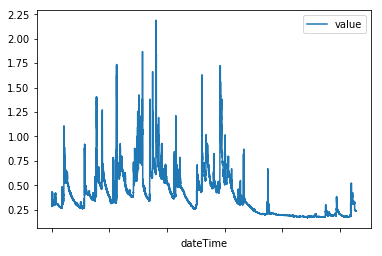

In [6]:
%matplotlib inline  
exe_bridges_in_memory.sort_values(by='dateTime')
exe_bridges_in_memory.value = exe_bridges_in_memory.value.astype('float', copy=False)
exe_bridges_in_memory.plot.line(x="dateTime", y="value")